In [1]:
!nvidia-smi

Mon Mar 31 10:25:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Installing Dependences

In [7]:
!pip install ultralytics opencv-python numpy filterpy deep-sort-realtime pytubefix

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.5/731.5 kB 14.9 MB/s eta 0:00:00


Importing Required Libraries & Functions

In [8]:
import cv2
import numpy as np
from ultralytics import YOLO
from pytubefix import YouTube
from deep_sort_realtime.deepsort_tracker import DeepSort
from google.colab.patches import cv2_imshow  # Import for Colab display
import time
from IPython.display import display, Image, clear_output
import io
import PIL.Image


Laoding Video From Youtube

In [10]:
url = "https://www.youtube.com/watch?v=A9kqcnP6Hyo"
yt = YouTube(url)
stream = yt.streams.filter(progressive=True, file_extension="mp4").first()
if not stream:
    raise Exception("No suitable MP4 stream found.")
stream_url = stream.url

# Open the video stream
cap = cv2.VideoCapture(stream_url)
if not cap.isOpened():
    raise Exception("Error: Could not open video stream")


Loading the Pretrained Model

In [11]:
# Load cutom trained YOLO model
model = YOLO("best.pt") # I used a pretrained model which is trianed on roboflow basketball dataset

# Initialize DeepSORT tracker
tracker = DeepSort(max_age=30)  # Keeps tracking objects even if they disappear briefly

# Team score variables
score_team_A = 0
score_team_B = 0

# Store player data
player_data = {}  # {track_id: {"bbox": (x1, y1, x2, y2), "team": "Team A" or "Team B"}}


In [42]:
def detect_team(player_bbox, frame):
    """Detects player jersey color to classify teams using HSV color space."""
    x1, y1, x2, y2 = player_bbox
    h, w, _ = frame.shape  # Get frame dimensions

    # Ensure bounding box is within the frame
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(w, x2), min(h, y2)

    if x1 >= x2 or y1 >= y2:  # Invalid bounding box
        return "Unknown"

    jersey_region = frame[y1:y1 + (y2 - y1) // 2, x1:x2]

    # Ensure jersey_region is not empty
    if jersey_region.size == 0:
        return "Unknown"

    # Convert to HSV for better color robustness
    jersey_hsv = cv2.cvtColor(jersey_region, cv2.COLOR_BGR2HSV)
    avg_hsv = np.mean(jersey_hsv, axis=(0, 1))  # [H, S, V]

    # Define team colors in HSV (example values, adjust based on real data)
    team_A_color_hsv = np.array([0, 200, 200])    # Red-ish hue
    team_B_color_hsv = np.array([120, 200, 200])  # Blue-ish hue

    # Compare hue distances (ignore S, V for simplicity)
    hue_dist_A = min(abs(avg_hsv[0] - team_A_color_hsv[0]), 360 - abs(avg_hsv[0] - team_A_color_hsv[0]))
    hue_dist_B = min(abs(avg_hsv[0] - team_B_color_hsv[0]), 360 - abs(avg_hsv[0] - team_B_color_hsv[0]))

    return "Team A" if hue_dist_A < hue_dist_B else "Team B"


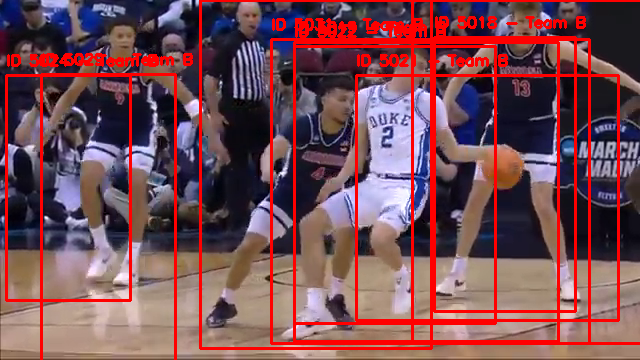


0: 384x640 3 Players, 25.2ms
Speed: 1.9ms preprocess, 25.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


In [ ]:
# Initialize team scores
score_team_A = 0
score_team_B = 0

# Open the video stream with OpenCV
cap = cv2.VideoCapture(stream_url)

ball_in_rim = False  # Initialize ball state

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    results = model(frame)  # Run YOLO on the frame
    detections = []

    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            label = result.names[int(box.cls[0].item())]
            conf = float(box.conf[0].item())

            if label == "Player":
                detections.append(([x1, y1, x2 - x1, y2 - y1], conf, label))

    tracks = tracker.update_tracks(detections, frame=frame)

    for track in tracks:
        if not track.is_confirmed():
            continue

        track_id = track.track_id
        ltrb = track.to_ltrb()
        x1, y1, x2, y2 = map(int, ltrb)

        if track_id not in player_data:
            team = detect_team((x1, y1, x2, y2), frame)  # Assign team
            player_data[track_id] = {"bbox": (x1, y1, x2, y2), "team": team}

        # Draw bounding box & team label
        team = player_data[track_id]["team"]
        color = (255, 0, 0) if team == "Team A" else (0, 0, 255)
        cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
        cv2.putText(frame, f"ID {track_id} - {team}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    ball_bbox = None
    hoop_bbox = None

    for result in results:
        for box in result.boxes:
            label = result.names[int(box.cls[0].item())]
            x1, y1, x2, y2 = map(int, box.xyxy[0])

            if label == "Ball":
                ball_bbox = (x1, y1, x2, y2)
            elif label == "Hoop":
                hoop_bbox = (x1, y1, x2, y2)

    if ball_bbox and hoop_bbox:
        ball_x1, ball_y1, ball_x2, ball_y2 = ball_bbox
        hoop_x1, hoop_y1, hoop_x2, hoop_y2 = hoop_bbox

        ball_center_y = (ball_y1 + ball_y2) // 2
        rim_y = hoop_y1 + int((hoop_y2 - hoop_y1) * 0.3)
        net_y = hoop_y2

        # Detect if ball is in the rim
        if rim_y <= ball_center_y <= net_y:
            ball_in_rim = True

        # Check if ball has passed through the hoop
        if ball_in_rim and ball_center_y > net_y:
            print("SHOT MADE!")

            # Find the shooter
            shooter_id = None
            min_distance = float("inf")

            for track_id, data in player_data.items():
                player_x1, _, player_x2, _ = data["bbox"]
                distance = abs(ball_x1 - (player_x1 + player_x2) // 2)

                if distance < min_distance:
                    min_distance = distance
                    shooter_id = track_id

            if shooter_id:
                team = player_data[shooter_id]["team"]
                points = 3 if abs(player_data[shooter_id]["bbox"][0] - hoop_x1) > 200 else 2  # 3-pointer if far

                if team == "Team A":
                    score_team_A += points
                else:
                    score_team_B += points

                print(f"🏀 {team} Scored {points} Points! Score: Team A - {score_team_A} | Team B - {score_team_B}")

            ball_in_rim = False  # Reset state after scoring

    # Display the updated frame
    clear_output(wait=True)  # Clears previous frames
    cv2_imshow(frame)

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()